Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9845 entries, 0 to 9844
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  9845 non-null   object
 1   label     9845 non-null   object
dtypes: object(2)
memory usage: 154.0+ KB
None

All Data:
                                                      filename   label
                                              a.0JWo-James.jpg       a
                                      a.0xvU-Lutian Grace .jpg       a
                                              a.11PX-James.jpg       a
                                              a.1CQN-James.jpg       a
                                      a.1Jjh-Lutian Grace .jpg       a
                                              a.2aoN-James.jpg       a
                                      a.2cqF-Luntian Grace.jpg       a
                                              a.30tp-James.jpg       a
                            

C:\Users\Sam\AppData\Local\Temp\ipykernel_23496\101932157.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=char_df, x='character', y='count', palette='crest')


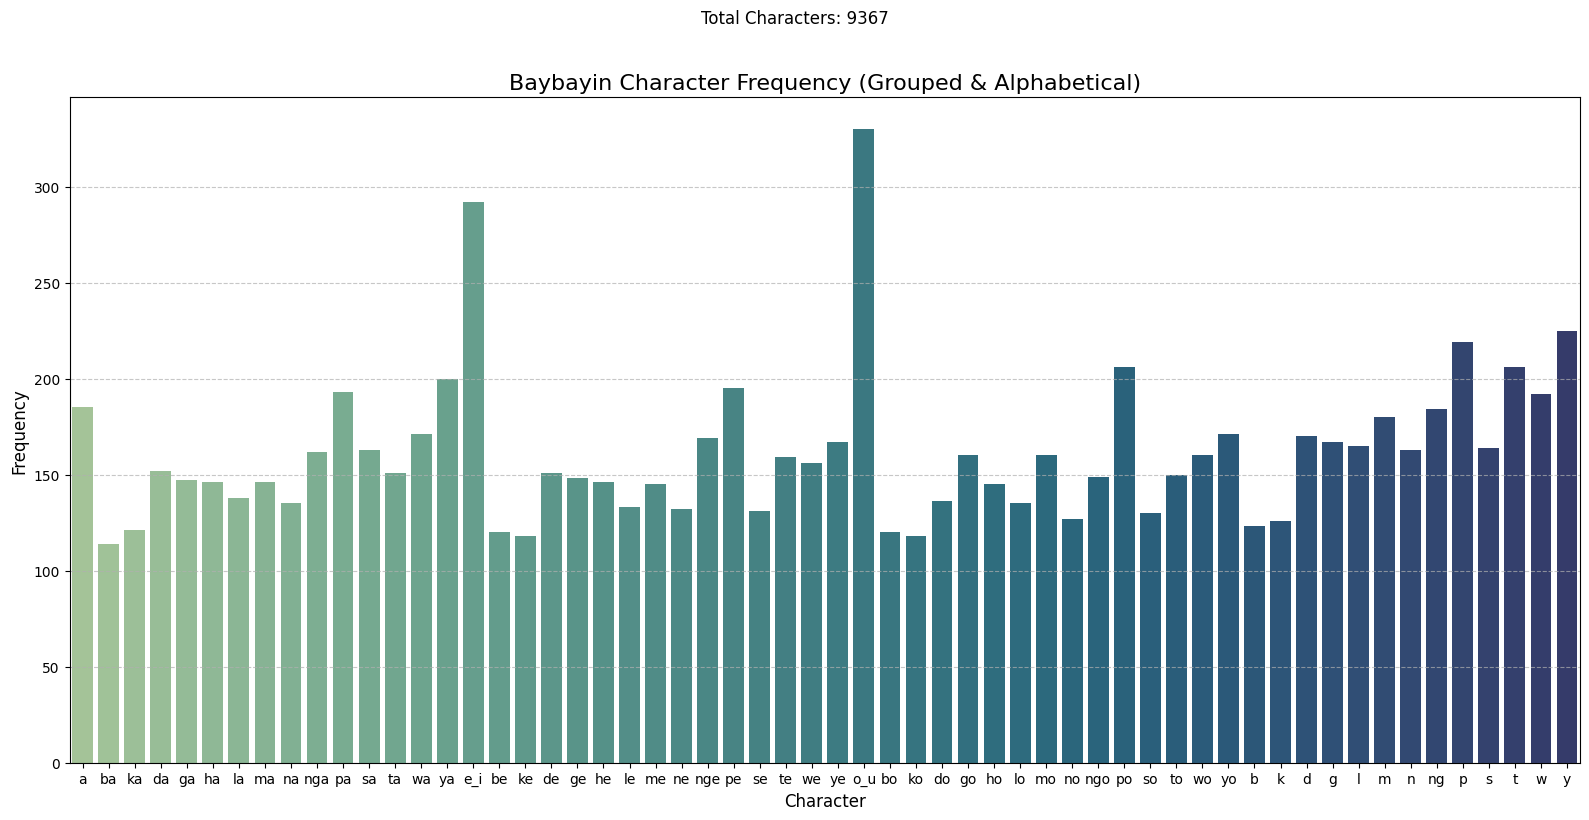


📘 Label Group Summary:
     label_group  count
0      no_kudlit   4320
1     top_kudlit   1780
2  bottom_kudlit   1758
3   unclassified   1021
4   cross_kudlit    781
5          vowel    185


C:\Users\Sam\AppData\Local\Temp\ipykernel_23496\101932157.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=group_counts, x='count', y='label_group', palette='viridis')


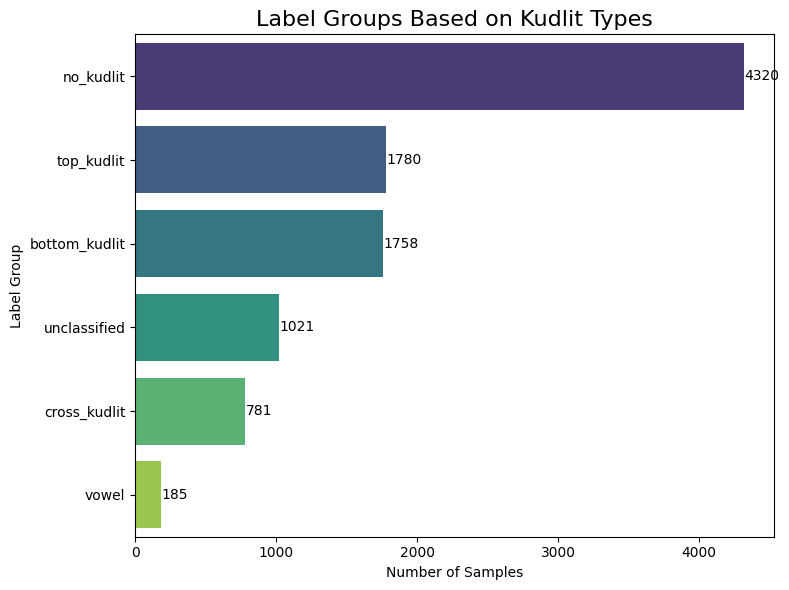

C:\Users\Sam\AppData\Local\Temp\ipykernel_23496\101932157.py:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=kudlit_summary_filtered, x="Count", y="Type", palette="rocket")


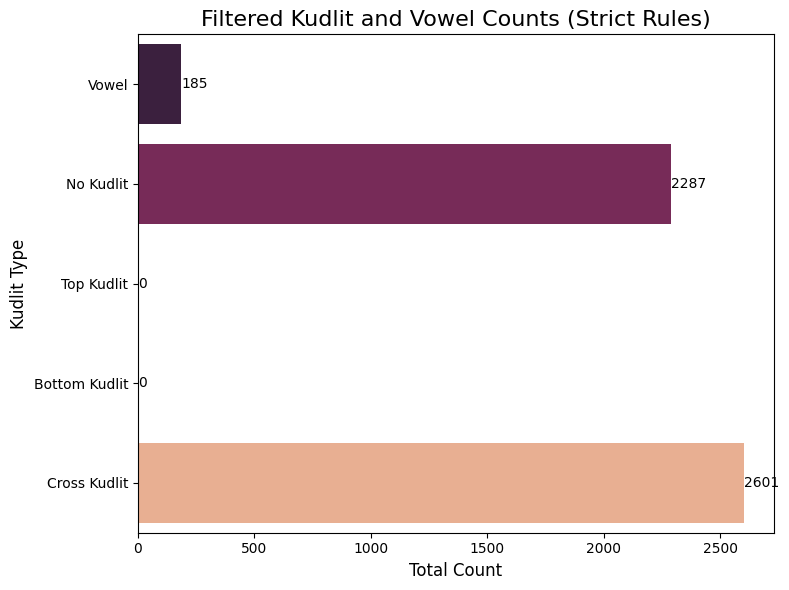

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os
import cv2
import numpy as np

# Load CSV File with Labels
csv_file = "pics_labels.csv"
df = pd.read_csv(csv_file)

if 'filename' not in df.columns or 'label' not in df.columns:
    print("CSV file must contain 'filename' and 'label' columns.")
    exit()

print("Dataset Summary:")
print(df.info())
print("\nAll Data:")
print(df.to_string(index=False))

# Kudlit Detection Section
def detect_kudlits(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return {"top_kudlit": 0, "bottom_kudlit": 0, "cross_under": 0}

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    height = img.shape[0]
    top_kudlit = 0
    bottom_kudlit = 0
    cross_under = 0

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h

        if area < 150:
            center_y = y + h // 2
            if center_y < height * 0.3:
                top_kudlit += 1
            elif center_y > height * 0.7:
                bottom_kudlit += 1
                aspect_ratio = w / float(h)
                if 0.8 < aspect_ratio < 1.2:
                    cross_under += 1

    return {
        "top_kudlit": top_kudlit,
        "bottom_kudlit": bottom_kudlit,
        "cross_under": cross_under
    }

# Process all images
image_folder = "Dataset"
kudlit_data = []

for _, row in df.iterrows():
    image_path = os.path.join(image_folder, row['filename'])
    kudlit_info = detect_kudlits(image_path)
    kudlit_data.append(kudlit_info)

# Merge kudlit info
df = pd.concat([df, pd.DataFrame(kudlit_data)], axis=1)

print("\nData with kudlit detection:")
print(df.to_string(index=False))

# 3. Baybayin Character Frequency (Grouped and Alphabetical)

# Define character mapping based on the chart
baybayin_letters = [
    'a', 'ba', 'ka', 'da', 'ga', 'ha', 'la', 'ma', 'na', 'nga', 'pa', 'sa', 'ta', 'wa', 'ya',
    'e_i', 'be', 'ke', 'de', 'ge', 'he', 'le', 'me', 'ne', 'nge', 'pe', 'se', 'te', 'we', 'ye',
    'o_u', 'bo', 'ko', 'do', 'go', 'ho', 'lo', 'mo', 'no', 'ngo', 'po', 'so', 'to', 'wo', 'yo',
    'b', 'k', 'd', 'g', 'l', 'm', 'n', 'ng', 'p', 's', 't', 'w', 'y'
]

# Flatten and normalize
labels = df['label'].str.replace('-', '').str.split('_').explode().dropna()
def normalize_baybayin_char(char):
    if char in ['e', 'i']:
        return 'e_i'
    elif char in ['o', 'u']:
        return 'o_u'
    return char

normalized = labels.apply(normalize_baybayin_char)
char_counts = normalized.value_counts().to_dict()
char_counts_complete = {char: char_counts.get(char, 0) for char in baybayin_letters}
char_df = pd.DataFrame(list(char_counts_complete.items()), columns=['character', 'count'])

plt.figure(figsize=(16, 8))
sns.barplot(data=char_df, x='character', y='count', palette='crest')

plt.title("Baybayin Character Frequency (Grouped & Alphabetical)", fontsize=16)
plt.xlabel("Character", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle(f"Total Characters: {char_df['count'].sum()}", fontsize=12, y=1.02)

plt.tight_layout()
plt.show()

# 🔎 Label Group Classification (based on kudlit type and label content)
def classify_label_group(row):
    label = row['label'].replace('-', '_')
    parts = label.split('_')

    if len(parts) == 1 and parts[0] in ['a', 'e', 'i', 'o', 'u', 'o_u', 'e_i']:
        return 'vowel'

    if row['top_kudlit'] > 0 and any(p.endswith(('e', 'i')) for p in parts):
        return 'top_kudlit'
    if row['bottom_kudlit'] > 0 and any(p.endswith(('o', 'u')) for p in parts):
        return 'bottom_kudlit'
    if row['cross_under'] > 0 and any(p in cross_consonants_explicit for p in parts):
        return 'cross_kudlit'
    if row['top_kudlit'] == 0 and row['bottom_kudlit'] == 0 and row['cross_under'] == 0:
        return 'no_kudlit'
    return 'unclassified'

# Apply classification
df['label_group'] = df.apply(classify_label_group, axis=1)

# 📊 Count and visualize
group_counts = df['label_group'].value_counts().reset_index()
group_counts.columns = ['label_group', 'count']

print("\n📘 Label Group Summary:")
print(group_counts)

# 🔥 Visualization
plt.figure(figsize=(8, 6))
sns.barplot(data=group_counts, x='count', y='label_group', palette='viridis')

for i, row in group_counts.iterrows():
    plt.text(row['count'] + 1, i, str(row['count']), va='center', fontsize=10)

plt.title("Label Groups Based on Kudlit Types", fontsize=16)
plt.xlabel("Number of Samples")
plt.ylabel("Label Group")

plt.tight_layout()
plt.show()


# 📊 Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=kudlit_summary_filtered, x="Count", y="Type", palette="rocket")

for i, row in kudlit_summary_filtered.iterrows():
    plt.text(row['Count'] + 0.5, i, str(row['Count']), va='center', fontsize=10)

plt.title("Filtered Kudlit and Vowel Counts (Strict Rules)", fontsize=16)
plt.xlabel("Total Count", fontsize=12)
plt.ylabel("Kudlit Type", fontsize=12)

plt.tight_layout()
plt.show()
